In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

In [16]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K) + (r + 0.5 *sig**2) * T )/(sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def bsput(S, K, T, r, sig):
    d1 = (np.log(S / K) + (r + 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sig ** 2) * T) / (sig * np.sqrt(T))
    return K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)

In [17]:
# ======== 1 ======== #
r = 0.00 # 0.0으로 두면 계산이 편해짐 -> 이자율만 이야기함.
sig = 0.2  # 주식의 변동성 - 20%가 가장 흔히 쓰는 주식의 변동성
T = 30/365 # 1년 중 30일

M = 1000 # 시뮬레이션 수 ( 100개의 시나리오를 테스트하겠다. )
N = 30 # 나눔수

dt = T/N # T를 N개로 나눠서 보겠다.
rdt = r * dt
sigsdt = sig * np.sqrt(dt)

# ======== 2 ======== #
S0 = 100
np.random.seed(100) # 랜덤 변수 고정
S = np.empty([M,N+1]) # 100 * 31 배열
rv = np.random.normal(r*dt, sigsdt, [M,N])

# ======== 3 ======== #
for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1 + rv[i,j])

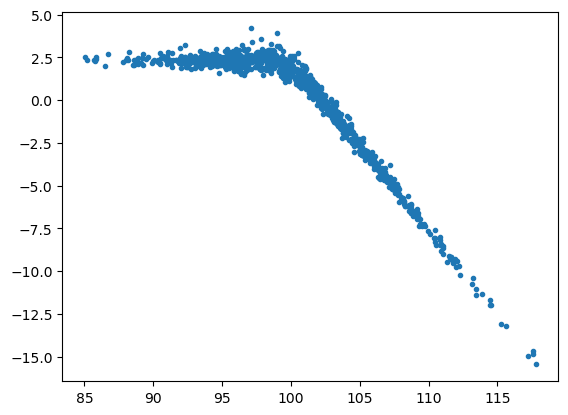

In [18]:
a = []
K = 100

for i in range(M):
    cost = 0
    price = S[i,0]
    for j in range(N):
        d1 = (np.log(S[i,j]/K) + (r + 0.5 *sig**2) * (T-j*dt))/(sig * np.sqrt(T-j*dt)) # Black Scholes의 Call option delta
        delta = norm.cdf(d1)
        cost = cost + delta * (price-S[i,j+1])
        price = S[i,j+1]



    # cost = cost + np.maximum(S[i, N] - K, 0)
    a.append(cost)

plt.plot(S[:,-1], a, marker=".", linestyle='none')
plt.show()

In [19]:
my_input = []

hedge_cost = tf.keras.layers.Input(shape=(1,), name='hedge_cost')
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape=(1,), name='price')
my_input = my_input + [price]

for j in range(3):
    delta = tf.keras.layers.Dense(1, name=str(j))(price)

    new_price = tf.keras.layers.Input(shape=(1,), name="S_"+str(j))
    my_input = my_input + [new_price]

    price_inc = tf.keras.layers.Subtract(name="price_inc"+str(j))([price,new_price])
    cost = tf.keras.layers.Multiply(name="multiply"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name="cost_"+str(j))([hedge_cost, cost])
    price = new_price

model = tf.keras.Model(inputs=my_input, outputs=hedge_cost)

tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
my_input = []

premium = tf.keras.layers.Input(shape=(1,), name="premium")
my_input = my_input + [premium]


hedge_cost = tf.keras.layers.Input(shape=(1,), name="hedge_cost")
my_input = my_input + [hedge_cost]

price = tf.keras.layers.Input(shape=(1,), name="price")
my_input = my_input + [price]

for j in range(N):

  delta = tf.keras.layers.Dense(32, activation='tanh')(price)
  # delta = tf.keras.layers.BatchNormalization()(delta)

  # delta = tf.keras.layers.Dense(32, activation='relu')(price)
  # delta = tf.keras.layers.BatchNormalization()(delta)

  # delta = tf.keras.layers.Dense(32, activation='tanh')(price)
  # delta = tf.keras.layers.BatchNormalization()(delta)

  delta = tf.keras.layers.Dense(1)(delta)

  new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j))
  my_input = my_input + [new_price]

  price_inc = tf.keras.layers.Subtract(name="price_inc"+str(j))([price,new_price])
  cost = tf.keras.layers.Multiply(name="multiply"+str(j))([delta, price_inc])
  hedge_cost = tf.keras.layers.Add(name="cost_"+str(j))([hedge_cost, cost])
  price = new_price

payoff = tf.keras.layers.Lambda(lambda x : 0.5*(tf.abs(x-K) + x - K))(price)
cum_cost = tf.keras.layers.Add(name='final')([hedge_cost, payoff])
cum_cost = tf.keras.layers.Subtract(name='final_')([cum_cost, premium])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)

tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# p = 2.2871506280449694 * np.ones([M,1])
# c = np.zeros([M,1])
# SS = [S[:,1].reshape(M,1) for i in range(N+1)]
# x = [p] + [c] + [SS]
# y = np.zeros([M,1])

S0 = 100
K = 100
T = 30/365
r = 0.0
sig = 0.2

p = bscall(S0,K,T,r,sig) * np.ones([M,1])
c = np.zeros([M,1])
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
x = [p]+[c]+[SS]
y = bscall(S0,K,T,r,sig) * np.zeros([M,1])

In [22]:
model.compile(loss='mse', optimizer='adam')

In [12]:
model.fit(x,y, epochs=100)

Epoch 1/100


2022-09-29 13:54:12.658923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-29 13:54:13.555177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 4s 44ms/step - loss: 53.3429
Epoch 2/100
32/32 [==============================] - 1s 31ms/step - loss: 11.9249
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 3.7805
Epoch 4/100
32/32 [==============================] - 1s 30ms/step - loss: 2.9058
Epoch 5/100
32/32 [==============================] - 1s 31ms/step - loss: 2.7711
Epoch 6/100
32/32 [==============================] - 1s 31ms/step - loss: 2.7960
Epoch 7/100
32/32 [==============================] - 1s 30ms/step - loss: 2.7595
Epoch 8/100
32/32 [==============================] - 1s 31ms/step - loss: 2.7571
Epoch 9/100
32/32 [==============================] - 1s 30ms/step - loss: 2.7627
Epoch 10/100
32/32 [==============================] - 1s 31ms/step - loss: 2.7798
Epoch 11/100
32/32 [==============================] - 1s 30ms/step - loss: 2.7362
Epoch 12/100
32/32 [==============================] - 1s 30ms/step - loss: 2.7375
Epoch 13/100
32/32 [===============

2022-09-29 13:56:57.727004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 19ms/step


(array([ 80., 208., 228., 175., 136.,  78.,  59.,  21.,   9.,   6.]),
 array([-2.853526  , -1.9695169 , -1.0855076 , -0.20149831,  0.682511  ,
         1.5665202 ,  2.4505296 ,  3.3345387 ,  4.218548  ,  5.102557  ,
         5.9865665 ], dtype=float32),
 <BarContainer object of 10 artists>)

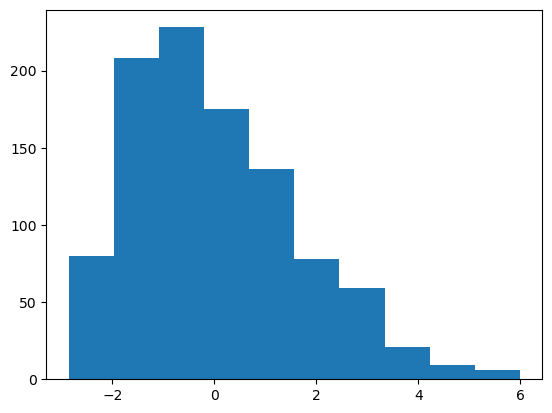

In [13]:
plt.hist(model.predict(x))